In [ ]:
#필요한 모듈 import


import requests
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


import random
from tqdm import tqdm

import numpy as np
from numpy import dot
from numpy.linalg import norm

from sklearn.cluster import KMeans

Task1

In [ ]:
# Task1-1
url="https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
r=requests.get(url)
open('movielens.zip','wb').write(r.content)
zipfile.ZipFile("movielens.zip").extractall()
filePath="ml-latest-small/"

ratings_data=pd.read_csv(filePath+"ratings.csv")


train, test = train_test_split(ratings_data,test_size=0.2)


In [ ]:
# Task1-2
movies_data1=pd.read_csv(filePath+"movies.csv")
for_make_movie_new=[]
for index, i in movies_data1.iterrows():
  movies_data_genres=i[2]
  genre_set=set(movies_data_genres.split("|"))
  for_make_movie_new.append([int(i[0]),i[1],genre_set])
movies_data=pd.DataFrame(for_make_movie_new, columns=["movieId","title","genres"])
print(movies_data)

      movieId  ...                                             genres
0           1  ...  {Children, Comedy, Animation, Adventure, Fantasy}
1           2  ...                     {Adventure, Children, Fantasy}
2           3  ...                                  {Comedy, Romance}
3           4  ...                           {Comedy, Romance, Drama}
4           5  ...                                           {Comedy}
...       ...  ...                                                ...
9737   193581  ...               {Comedy, Action, Animation, Fantasy}
9738   193583  ...                       {Comedy, Fantasy, Animation}
9739   193585  ...                                            {Drama}
9740   193587  ...                                {Action, Animation}
9741   193609  ...                                           {Comedy}

[9742 rows x 3 columns]


In [ ]:
# Task1-3

tags_data=pd.read_csv(filePath+"tags.csv")[["movieId","tag"]]
tags_data_dict={}
for idx in tags_data.index:
  mv_id=tags_data['movieId'][idx]
  tag_set=tags_data["tag"][idx].lower()
  if mv_id in tags_data_dict: tags_data_dict[mv_id].append(tag_set)
  else: 
    tags_data_dict[mv_id]=[tag_set]

for key, val in tags_data_dict.items():
  tags_data_dict[key]=set(val)
tags_data_dict=sorted(tags_data_dict.items())

columns=['movieId', 'tag']
new_tag_data=pd.DataFrame(tags_data_dict)
new_tag_data.rename(columns={0:"movieId",1:"tag"},inplace=True)
new_tag_data

,movieId,tag
0,1,"{pixar, fun}"
1,2,"{fantasy, game, magic board game, robin williams}"
2,3,"{moldy, old}"
3,5,"{pregnancy, remake}"
4,7,{remake}
...,...,...
1567,183611,"{comedy, rachel mcadams, funny}"
1568,184471,"{adventure, video game adaptation, alicia vika..."
1569,187593,"{ryan reynolds, sarcasm, josh brolin}"
1570,187595,"{emilia clarke, star wars}"


Task2

In [ ]:
# Task2-1
movies = torch.LongTensor(train['movieId'])
users = torch.LongTensor(train['userId'])
ratings = torch.FloatTensor(train['rating'])
movies_test = torch.LongTensor(test['movieId'].values)
users_test = torch.LongTensor(test['userId'].values)
ratings_test = torch.FloatTensor(test['rating'].values)


rank = 10
numMovies= movies.max()+1
numUsers = users.max()+1

P = torch.randn(numMovies, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001


bias_movie = torch.randn(numMovies, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()
optimizer = torch.optim.Adam([P, Q, bias_movie, bias_user], lr= 0.1)

X = []
Y = []
Y_test = []
for epoch in range(1001):
  hypothesis = torch.sum(P[movies] * Q[users], dim=1) + mean +\
   bias_movie[movies] + bias_user[users]


  cost = F.mse_loss(hypothesis ,ratings)
  loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) \
  + lambda3 * torch.sum(bias_movie ** 2) + lambda4 * torch.sum(bias_user ** 2) 
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  with torch.no_grad():
    hypo_test = torch.sum(P[movies_test] * Q[users_test], dim=1)+ mean + bias_movie[movies_test] + bias_user[users_test]
    cost_test = F.mse_loss(hypo_test, ratings_test)
    
    X.append(epoch)
    Y.append(cost)
    Y_test.append(cost_test)

  if epoch % 100 == 0:
    print("epoch: {}, cost: {}".format(epoch, cost.item()))


epoch: 0, cost: 13.060781478881836
epoch: 100, cost: 0.4419422447681427
epoch: 200, cost: 0.4182038903236389
epoch: 300, cost: 0.4131897985935211
epoch: 400, cost: 0.41092076897621155
epoch: 500, cost: 0.4095882773399353
epoch: 600, cost: 0.40839719772338867
epoch: 700, cost: 0.40738674998283386
epoch: 800, cost: 0.4067833423614502
epoch: 900, cost: 0.4064432978630066
epoch: 1000, cost: 0.40623271465301514


Task2-1 
hyper parameter (learning rate, regularization weight 등) 탐색

epoch: 0, cost: 13.085794448852539
epoch: 100, cost: 0.26459363102912903
epoch: 200, cost: 0.2140101045370102
epoch: 300, cost: 0.19975405931472778
epoch: 400, cost: 0.19395819306373596
epoch: 500, cost: 0.1908423900604248
epoch: 600, cost: 0.1886610984802246
epoch: 700, cost: 0.18724428117275238
epoch: 800, cost: 0.18625500798225403
epoch: 900, cost: 0.18549251556396484
epoch: 1000, cost: 0.1847832202911377


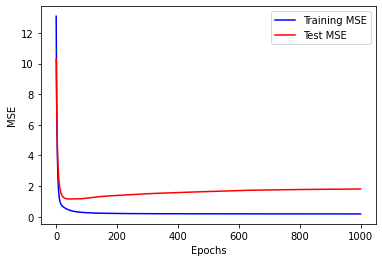

In [84]:
# Task2-1 추가학습 - regularization weight 줄이기
movies = torch.LongTensor(train['movieId'])
users = torch.LongTensor(train['userId'])
ratings = torch.FloatTensor(train['rating'])
movies_test = torch.LongTensor(test['movieId'].values)
users_test = torch.LongTensor(test['userId'].values)
ratings_test = torch.FloatTensor(test['rating'].values)


rank = 10
numMovies= movies.max()+1
numUsers = users.max()+1

P = torch.randn(numMovies, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

lambda1 = 0.000001
lambda2 = 0.000001
lambda3 = 0.001
lambda4 = 0.001


bias_movie = torch.randn(numMovies, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()
optimizer = torch.optim.Adam([P, Q, bias_movie, bias_user], lr= 0.1)

X1 = []
Y1 = []
Y1_test = []
for epoch in range(1001):
  hypothesis = torch.sum(P[movies] * Q[users], dim=1) + mean +\
   bias_movie[movies] + bias_user[users]


  cost = F.mse_loss(hypothesis ,ratings)
  loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) \
  + lambda3 * torch.sum(bias_movie ** 2) + lambda4 * torch.sum(bias_user ** 2) 
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  with torch.no_grad():
    hypo_test = torch.sum(P[movies_test] * Q[users_test], dim=1)+ mean + bias_movie[movies_test] + bias_user[users_test]
    cost_test = F.mse_loss(hypo_test, ratings_test)
    
    X1.append(epoch)
    Y1.append(cost)
    Y1_test.append(cost_test)

  if epoch % 100 == 0:
    print("epoch: {}, cost: {}".format(epoch, cost.item()))


#그래프 그리기
plt.ylabel("MSE")
plt.xlabel("Epochs")
plt.plot(X1,Y1, c="blue", label="Training MSE")
plt.plot(X1,Y1_test, c="red", label="Test MSE")
plt.legend()
plt.show()


epoch: 0, cost: 12.961583137512207
epoch: 100, cost: 0.8139623999595642
epoch: 200, cost: 0.8139804005622864
epoch: 300, cost: 0.8139849901199341
epoch: 400, cost: 0.8139811754226685
epoch: 500, cost: 0.8139849901199341
epoch: 600, cost: 0.8139809966087341
epoch: 700, cost: 0.813983678817749
epoch: 800, cost: 0.8139740228652954
epoch: 900, cost: 0.813983678817749
epoch: 1000, cost: 0.8139790296554565


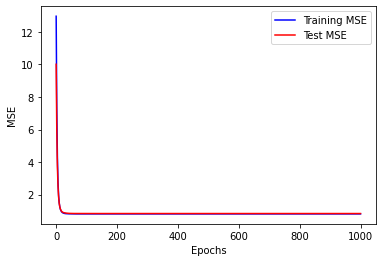

In [85]:
# Task2-1 추가학습 - regularization weight 늘이기


P = torch.randn(numMovies, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

lambda1 = 0.001
lambda2 = 0.001
lambda3 = 0.001
lambda4 = 0.001


bias_movie = torch.randn(numMovies, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()
optimizer = torch.optim.Adam([P, Q, bias_movie, bias_user], lr= 0.1)

X2 = []
Y2 = []
Y2_test = []
for epoch in range(1001):
  hypothesis = torch.sum(P[movies] * Q[users], dim=1) + mean +\
   bias_movie[movies] + bias_user[users]


  cost = F.mse_loss(hypothesis ,ratings)
  loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) \
  + lambda3 * torch.sum(bias_movie ** 2) + lambda4 * torch.sum(bias_user ** 2) 
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  with torch.no_grad():
    hypo_test = torch.sum(P[movies_test] * Q[users_test], dim=1)+ mean + bias_movie[movies_test] + bias_user[users_test]
    cost_test = F.mse_loss(hypo_test, ratings_test)
    
    X2.append(epoch)
    Y2.append(cost)
    Y2_test.append(cost_test)

  if epoch % 100 == 0:
    print("epoch: {}, cost: {}".format(epoch, cost.item()))


#그래프 그리기
plt.ylabel("MSE")
plt.xlabel("Epochs")
plt.plot(X2,Y2, c="blue", label="Training MSE")
plt.plot(X2,Y2_test, c="red", label="Test MSE")
plt.legend()
plt.show()


epoch: 0, cost: 12.862264633178711
epoch: 10, cost: 1.3235162496566772
epoch: 20, cost: 0.7983303070068359
epoch: 30, cost: 0.7019239664077759
epoch: 40, cost: 0.6321048736572266
epoch: 50, cost: 0.5634694695472717


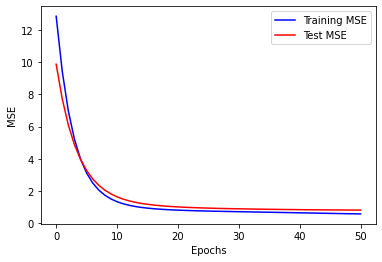

In [86]:
# Task2-1 추가학습 - epoch 줄이기

P = torch.randn(numMovies, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001


bias_movie = torch.randn(numMovies, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()
optimizer = torch.optim.Adam([P, Q, bias_movie, bias_user], lr= 0.1)

X3 = []
Y3 = []
Y3_test = []
for epoch in range(51):
  hypothesis = torch.sum(P[movies] * Q[users], dim=1) + mean +\
   bias_movie[movies] + bias_user[users]


  cost = F.mse_loss(hypothesis ,ratings)
  loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) \
  + lambda3 * torch.sum(bias_movie ** 2) + lambda4 * torch.sum(bias_user ** 2) 
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  with torch.no_grad():
    hypo_test = torch.sum(P[movies_test] * Q[users_test], dim=1)+ mean + bias_movie[movies_test] + bias_user[users_test]
    cost_test = F.mse_loss(hypo_test, ratings_test)
    
    X3.append(epoch)
    Y3.append(cost)
    Y3_test.append(cost_test)

  if epoch % 10 == 0:
    print("epoch: {}, cost: {}".format(epoch, cost.item()))


#그래프 그리기
plt.ylabel("MSE")
plt.xlabel("Epochs")
plt.plot(X3,Y3, c="blue", label="Training MSE")
plt.plot(X3,Y3_test, c="red", label="Test MSE")
plt.legend()
plt.show()


epoch: 0, cost: 12.486638069152832
epoch: 100, cost: 0.44269219040870667
epoch: 200, cost: 0.4174136221408844
epoch: 300, cost: 0.4117441773414612
epoch: 400, cost: 0.40943145751953125
epoch: 500, cost: 0.40847048163414
epoch: 600, cost: 0.4079892933368683
epoch: 700, cost: 0.4075990319252014
epoch: 800, cost: 0.40732577443122864
epoch: 900, cost: 0.40719136595726013
epoch: 1000, cost: 0.40713000297546387
epoch: 1100, cost: 0.4070446789264679
epoch: 1200, cost: 0.4069404602050781
epoch: 1300, cost: 0.4068540036678314
epoch: 1400, cost: 0.4067727327346802
epoch: 1500, cost: 0.40669509768486023
epoch: 1600, cost: 0.40661028027534485
epoch: 1700, cost: 0.4065566658973694
epoch: 1800, cost: 0.40652355551719666
epoch: 1900, cost: 0.4065017104148865
epoch: 2000, cost: 0.4064970016479492


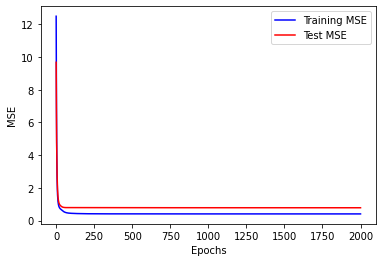

In [87]:
# Task2-1 추가학습 - epoch 늘이기

P = torch.randn(numMovies, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001


bias_movie = torch.randn(numMovies, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()
optimizer = torch.optim.Adam([P, Q, bias_movie, bias_user], lr= 0.1)

X4 = []
Y4 = []
Y4_test = []
for epoch in range(2001):
  hypothesis = torch.sum(P[movies] * Q[users], dim=1) + mean +\
   bias_movie[movies] + bias_user[users]


  cost = F.mse_loss(hypothesis ,ratings)
  loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) \
  + lambda3 * torch.sum(bias_movie ** 2) + lambda4 * torch.sum(bias_user ** 2) 
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  with torch.no_grad():
    hypo_test = torch.sum(P[movies_test] * Q[users_test], dim=1)+ mean + bias_movie[movies_test] + bias_user[users_test]
    cost_test = F.mse_loss(hypo_test, ratings_test)
    
    X4.append(epoch)
    Y4.append(cost)
    Y4_test.append(cost_test)

  if epoch % 100 == 0:
    print("epoch: {}, cost: {}".format(epoch, cost.item()))


#그래프 그리기
plt.ylabel("MSE")
plt.xlabel("Epochs")
plt.plot(X4,Y4, c="blue", label="Training MSE")
plt.plot(X4,Y4_test, c="red", label="Test MSE")
plt.legend()
plt.show()


In [88]:
#2-2
movies = torch.LongTensor(train['movieId'])
users = torch.LongTensor(train['userId'])
ratings = torch.FloatTensor(train['rating'])
movies_test = torch.LongTensor(test['movieId'].values)
users_test = torch.LongTensor(test['userId'].values)
ratings_test = torch.FloatTensor(test['rating'].values)


rank = 10
numMovies= movies.max()+1
numUsers = users.max()+1

P = torch.randn(numMovies, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001


bias_movie = torch.randn(numMovies, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()
optimizer = torch.optim.Adam([P, Q, bias_movie, bias_user], lr= 0.1)

X = []
Y = []
Y_test = []

rmse_train=[]
rmse_test=[]
for epoch in range(1001):
  hypothesis = torch.sum(P[movies] * Q[users], dim=1) + mean +\
   bias_movie[movies] + bias_user[users]


  cost = F.mse_loss(hypothesis ,ratings)
  train_rmse=cost**0.5
  loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) \
  + lambda3 * torch.sum(bias_movie ** 2) + lambda4 * torch.sum(bias_user ** 2) 
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  with torch.no_grad():
    hypo_test = torch.sum(P[movies_test] * Q[users_test], dim=1)+ mean + bias_movie[movies_test] + bias_user[users_test]
    cost_test = F.mse_loss(hypo_test, ratings_test)
    test_rmse=cost_test**0.5
    X.append(epoch)
    Y.append(cost)
    rmse_train.append(train_rmse)
    rmse_test.append(test_rmse)
    Y_test.append(cost_test)

  if epoch % 100 == 0:
    print("epoch: {}, cost: {}, train_rmse: {}, test_rmse: {}".format(epoch, cost.item(),train_rmse.item(),test_rmse.item()))


epoch: 0, cost: 13.201268196105957, train_rmse: 3.633354902267456, test_rmse: 3.1936161518096924
epoch: 100, cost: 0.44581979513168335, train_rmse: 0.6676973700523376, test_rmse: 0.8922553658485413
epoch: 200, cost: 0.4213011860847473, train_rmse: 0.6490771770477295, test_rmse: 0.8896963000297546
epoch: 300, cost: 0.4141843318939209, train_rmse: 0.6435715556144714, test_rmse: 0.8886452913284302
epoch: 400, cost: 0.41087064146995544, train_rmse: 0.6409919261932373, test_rmse: 0.888099730014801
epoch: 500, cost: 0.40915077924728394, train_rmse: 0.639648973941803, test_rmse: 0.887012243270874
epoch: 600, cost: 0.40833231806755066, train_rmse: 0.6390088796615601, test_rmse: 0.8853263258934021
epoch: 700, cost: 0.4077986776828766, train_rmse: 0.6385911703109741, test_rmse: 0.8840177655220032
epoch: 800, cost: 0.4073788523674011, train_rmse: 0.6382623910903931, test_rmse: 0.8831490278244019
epoch: 900, cost: 0.40707552433013916, train_rmse: 0.6380246877670288, test_rmse: 0.8825768232345581
e

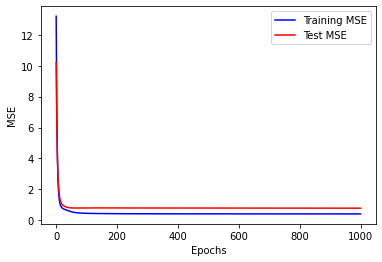

In [89]:
#그래프 그리기
plt.ylabel("MSE")
plt.xlabel("Epochs")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

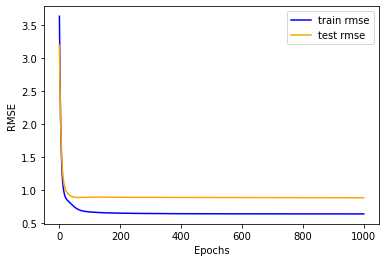

In [90]:
#그래프 그리기
plt.ylabel("RMSE")
plt.xlabel("Epochs")
plt.plot(X,rmse_train, c="blue", label="train rmse")
plt.plot(X,rmse_test, c="orange", label="test rmse")
plt.legend()
plt.show()

Task3를 위한 사전 작업

In [ ]:
def ratings_to_dict(ratings):
  return_dict = {}
  for index, i in ratings.iterrows():
    if int(i[0]) not in return_dict:
      return_dict[i[0]]={int(i[1]):i[2]}
    else:
      return_dict[i[0]][int(i[1])]=i[2]
  return return_dict

print(ratings_data)
ratings_dict=ratings_to_dict(ratings_data)
print(ratings_dict) #{사용자: {영화:평점}}

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]
{1.0: {1: 4.0, 3: 4.0, 6: 4.0, 47: 5.0, 50: 5.0, 70: 3.0, 101: 5.0, 110: 4.0, 151: 5.0, 157: 5.0, 163: 5.0, 216: 5.0, 223: 3.0, 231: 5.0, 235: 4.0, 260: 5.0, 296: 3.0, 316: 3.0, 333: 5.0, 349: 4.0, 356: 4.0, 362: 5.0, 367: 4.0, 423: 3.0, 441: 4.0, 457: 5.0, 480: 4.0, 500: 3.0, 527: 5.0, 543: 4.0, 552: 4.0, 553: 5.0, 590: 4.0, 592: 4.0, 593: 4.0, 596: 5.0, 608: 5.0, 648: 3.0, 661: 5.0, 673: 3.0, 733: 4.0, 736: 3.0, 780: 3.0, 804: 4.0, 919: 5.

In [ ]:
#movieid_name: id와 name match

movie_info=pd.merge(ratings_data,movies_data,on="movieId")
#print(movie_info)
movieid_name={}

for index, i in movie_info.iterrows():
  if int(i[1]) not in movie_info:
    movieid_name[int(i[1])]=i[4]





Task3-1

In [ ]:
tmp3_1={}
for i in range(numMovies.item()):
  tmp3_1[i]=torch.sum(P[i] * Q[514])+ mean + bias_movie[i] + bias_user[514]

recomm3_1=sorted(tmp3_1.items(), reverse=True, key=lambda item: item[1])
recomm3_1=recomm3_1[:20]

print(recomm3_1)

[(527, tensor(5.3553, grad_fn=<AddBackward0>)), (1196, tensor(4.9778, grad_fn=<AddBackward0>)), (912, tensor(4.9620, grad_fn=<AddBackward0>)), (318, tensor(4.9501, grad_fn=<AddBackward0>)), (79132, tensor(4.7491, grad_fn=<AddBackward0>)), (260, tensor(4.6544, grad_fn=<AddBackward0>)), (2324, tensor(4.5650, grad_fn=<AddBackward0>)), (2571, tensor(4.5439, grad_fn=<AddBackward0>)), (593, tensor(4.5263, grad_fn=<AddBackward0>)), (1193, tensor(4.5258, grad_fn=<AddBackward0>)), (3949, tensor(4.4961, grad_fn=<AddBackward0>)), (858, tensor(4.4704, grad_fn=<AddBackward0>)), (4878, tensor(4.4651, grad_fn=<AddBackward0>)), (4973, tensor(4.4461, grad_fn=<AddBackward0>)), (4226, tensor(4.4443, grad_fn=<AddBackward0>)), (1272, tensor(4.4295, grad_fn=<AddBackward0>)), (1617, tensor(4.4283, grad_fn=<AddBackward0>)), (1210, tensor(4.4176, grad_fn=<AddBackward0>)), (2858, tensor(4.4090, grad_fn=<AddBackward0>)), (2028, tensor(4.3879, grad_fn=<AddBackward0>))]


In [ ]:
for_df_3_1=[]
for mid, sim in recomm3_1:
  for_df_3_1.append([mid,movieid_name[mid]])

task3_1df=pd.DataFrame(for_df_3_1,columns=["movieId","title"])

print(task3_1df)

    movieId                                              title
0       527                            Schindler's List (1993)
1      1196  Star Wars: Episode V - The Empire Strikes Back...
2       912                                  Casablanca (1942)
3       318                   Shawshank Redemption, The (1994)
4     79132                                   Inception (2010)
5       260          Star Wars: Episode IV - A New Hope (1977)
6      2324         Life Is Beautiful (La Vita è bella) (1997)
7      2571                                 Matrix, The (1999)
8       593                   Silence of the Lambs, The (1991)
9      1193             One Flew Over the Cuckoo's Nest (1975)
10     3949                         Requiem for a Dream (2000)
11      858                              Godfather, The (1972)
12     4878                                Donnie Darko (2001)
13     4973  Amelie (Fabuleux destin d'Amélie Poulain, Le) ...
14     4226                                     Memento

===

Task 3-2



In [ ]:
def jaccard_similarity(a,b): #set 2개
  union=a|b
  inter=a&b
  return len(inter)/len(union)


In [ ]:

movies_real_data=[]
for index, i in movies_data.iterrows():
    movies_real_data.append(int(i[0]))


In [ ]:
for3_2data=pd.merge(left = movies_data , right = new_tag_data, how = "outer", on = "movieId")
for3_2data.fillna(0,inplace=True) #결측치 대체(추후, 오류 방지)
print(for3_2data)
print(for3_2data.columns.tolist())

      movieId  ...                                                tag
0           1  ...                                       {pixar, fun}
1           2  ...  {fantasy, game, magic board game, robin williams}
2           3  ...                                       {moldy, old}
3           4  ...                                                  0
4           5  ...                                {pregnancy, remake}
...       ...  ...                                                ...
9737   193581  ...                                                  0
9738   193583  ...                                                  0
9739   193585  ...                                                  0
9740   193587  ...                                                  0
9741   193609  ...                                                  0

[9742 rows x 4 columns]
['movieId', 'title', 'genres', 'tag']


In [ ]:
ratings514={}
for k in ratings_dict[514].keys():
  if (k not in movies_real_data) or (ratings_dict[514][k]!=5.0): continue
  ratings514[k]=ratings_dict[514][k]

appericated=set(list(ratings514))
not_appericated=list(set(movies_real_data)-appericated)
print("514 user가 5.0을 준 영화\n")
for k in ratings514.keys():
  print(k, " ",movieid_name[k])


514 user가 5.0을 준 영화

260   Star Wars: Episode IV - A New Hope (1977)
593   Silence of the Lambs, The (1991)
1196   Star Wars: Episode V - The Empire Strikes Back (1980)
1197   Princess Bride, The (1987)
1198   Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
1200   Aliens (1986)
1270   Back to the Future (1985)
1302   Field of Dreams (1989)
1387   Jaws (1975)
2398   Miracle on 34th Street (1947)
3471   Close Encounters of the Third Kind (1977)
6979   WarGames (1983)
26133   Charlie Brown Christmas, A (1965)
52435   How the Grinch Stole Christmas! (1966)
80463   Social Network, The (2010)


In [ ]:
for3_2data_dict={}
for index, i in for3_2data.iterrows():
  for3_2data_dict[int(i[0])]={}
  for3_2data_dict[int(i[0])]["genres"]=i[2]
  for3_2data_dict[int(i[0])]["tag"]=i[3]
  
#similarity 계산

jac_sim2={}
for a in appericated:
  jac_sim2[a]={}
  a_full=list(for3_2data_dict[a]['genres'])
  #결측치 처리 예외두기
  if for3_2data_dict[a]['tag']!=0: a_full+=list(for3_2data_dict[a]['tag'])
  a_tmp_set=set(a_full)
  for na in not_appericated:
    na_full=list(for3_2data_dict[na]['genres'])
    if for3_2data_dict[na]['tag']!=0: na_full+=list(for3_2data_dict[na]['tag'])
    na_tmp_set=set(na_full)
    js_tmp=jaccard_similarity(a_tmp_set,na_tmp_set)
    if js_tmp==0.0: continue
    jac_sim2[a][na]=js_tmp

#sorted
sorted_dict3_2=[]
for movie_app in jac_sim2.keys():
  tmp_set=sorted(jac_sim2[movie_app].items(), reverse=True,key=lambda item: (item[1]))
  sorted_dict3_2.append([movie_app,tmp_set[:5]])


#상위 다섯개씩 추출
sorted_dict3_2 = sorted(sorted_dict3_2, key = lambda x: (x[0]))

#dataframe으로 만든 뒤, 출력
for i in range(len(sorted_dict3_2)):
  mid=sorted_dict3_2[i][0]
  mnae=movieid_name[mid]
  t=sorted_dict3_2[i][1]
  
  lst=[]
  for j,si_m in t:
    lst.append([j,movieid_name[j],si_m])
  print(mid," ",mnae)
  print_3_2df=pd.DataFrame(lst,columns=["movieId","title","score"])
  print(print_3_2df)
    


260   Star Wars: Episode IV - A New Hope (1977)
   movieId                                              title     score
0     1210  Star Wars: Episode VI - Return of the Jedi (1983)  0.285714
1    33493  Star Wars: Episode III - Revenge of the Sith (...  0.238095
2   187595                     Solo: A Star Wars Story (2018)  0.173913
3    68358                                   Star Trek (2009)  0.172414
4     3793                                       X-Men (2000)  0.160000
593   Silence of the Lambs, The (1991)
   movieId                                      title     score
0     4725                           Session 9 (2001)  0.363636
1     2159  Henry: Portrait of a Serial Killer (1986)  0.333333
2     2389                              Psycho (1998)  0.333333
3     4645                                Cure (1997)  0.333333
4    70206                      Collector, The (2009)  0.333333
1196   Star Wars: Episode V - The Empire Strikes Back (1980)
   movieId                          

====

Task4를 위한 사전 작업

In [ ]:
s_item=sorted(set(ratings_data["movieId"].tolist()))
s_user=sorted(set(ratings_data["userId"].tolist()))
print(len(s_item),len(s_user))
print(s_item.index(122912))

9724 610
8675


In [ ]:
 
rank = 10
numItems = len(s_item)
numUsers = len(s_user)
new_P = torch.randn(numItems, rank, requires_grad=True)
new_Q = torch.randn(numUsers, rank, requires_grad=True)
b_item = torch.randn(numItems, requires_grad=True)
b_user = torch.randn(numUsers, requires_grad=True)


In [ ]:
Q_to_np=Q.detach().numpy()
new_Q_np=new_Q.detach().numpy()
print(new_Q_np)

new_P_np=new_P.detach().numpy()
P_to_np=P.detach().numpy()

[[-0.20787452 -0.18156531 -1.627776   ...  0.17475854  0.45271975
  -1.7473149 ]
 [ 0.6263902  -0.06545018 -1.7793012  ...  1.09003     0.44024056
   0.06725582]
 [-1.8887547  -0.46433252  0.06816907 ...  2.1472428  -1.1633834
  -0.3271364 ]
 ...
 [-0.39133647 -0.29025048  1.2306744  ... -0.09399895 -0.09905896
  -0.17882435]
 [-0.85686     0.24142334  1.350977   ... -0.2060715   0.27805287
   0.44397432]
 [ 1.0284921  -0.61633193 -1.0972095  ... -0.5878038   1.256588
  -0.85996515]]


====

In [47]:
# 코사인 유사도
def cosine_sim(user,other): # 1에 가까울수록 유사함.
  dot_p = np.dot(user,other)
  user_norms = sum([i**2 for i in user])**0.5
  other_norms = sum([i**2 for i in other])**0.5
  sum_norms = user_norms * other_norms

  return dot_p / sum_norms 


====

Task 4-1

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

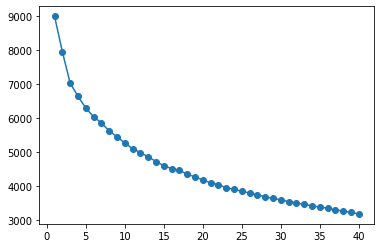

In [59]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
clu=[i for i in range(1,41)]
inertias=[]
sk={}
normor_P=preprocessing.normalize(P_to_np)
preds=[]

for i in clu:
  print(".",end=" ") #잘 돌아가는지 check
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(normor_P)
  inertias.append(kmeans.inertia_)
  
# Task4-2
plt.plot(clu, inertias,"o-")
plt.show()

In [93]:
print(inertias[1:])

print(inertias[1]-inertias[2]) #2-3
print(inertias[2]-inertias[3]) #3-4

[7943.7802734375, 7019.693359375, 6633.0224609375, 6290.0634765625, 6031.0458984375, 5848.77099609375, 5618.28125, 5445.13134765625, 5261.20556640625, 5091.98828125, 4977.50732421875, 4855.080078125, 4716.02783203125, 4592.90673828125, 4509.2890625, 4453.193359375, 4347.00390625, 4261.38818359375, 4176.34375, 4089.779296875, 4035.521484375, 3947.068115234375, 3895.7744140625, 3841.61865234375, 3790.013427734375, 3739.470458984375, 3676.9912109375, 3632.04638671875, 3593.806396484375, 3535.38671875, 3496.350830078125, 3453.79541015625, 3413.28515625, 3378.552734375, 3343.780517578125, 3299.203369140625, 3253.87158203125, 3221.1552734375, 3176.088134765625]
924.0869140625
386.6708984375


Task4-3

In [73]:
best_score_idx=3

kmeans = KMeans(n_clusters=best_score_idx)
kmeans.fit(normor_P)
clu=[i for i in range(1,41)]

cls=[[] for _ in range(best_score_idx)]

for a, i in zip(kmeans.labels_,range(new_P_np.shape[0])):
  cls[a].append(i)
  
new_ten=torch.from_numpy(new_P_np)

In [74]:
for i in range(len(cls)):
  print(cls[i])

[0, 1, 2, 3, 10, 11, 13, 17, 18, 19, 30, 33, 34, 35, 37, 38, 39, 43, 45, 48, 51, 52, 56, 58, 59, 61, 62, 67, 70, 72, 74, 76, 80, 83, 84, 85, 86, 90, 91, 98, 104, 106, 107, 109, 110, 112, 114, 115, 117, 120, 124, 127, 128, 130, 131, 133, 134, 136, 138, 139, 141, 142, 143, 144, 145, 148, 150, 151, 155, 156, 157, 161, 163, 164, 165, 167, 170, 177, 182, 188, 189, 190, 192, 197, 198, 200, 201, 202, 203, 205, 212, 216, 218, 219, 220, 221, 222, 226, 229, 230, 231, 232, 236, 237, 241, 242, 243, 244, 245, 249, 254, 261, 263, 264, 265, 266, 268, 279, 280, 282, 285, 286, 288, 292, 294, 297, 301, 303, 309, 310, 311, 313, 314, 316, 322, 323, 328, 329, 330, 333, 335, 336, 337, 342, 344, 346, 348, 349, 354, 356, 357, 359, 362, 364, 367, 368, 371, 375, 377, 378, 380, 381, 388, 390, 391, 392, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 407, 410, 411, 418, 439, 440, 443, 446, 447, 454, 457, 462, 463, 464, 465, 467, 468, 470, 471, 474, 480, 483, 487, 488, 490, 491, 492, 494, 498, 500, 503, 504

In [75]:
real_idx=-1
for i in range(len(cls)):
  ll=cls[i]
  try:
    ix=ll.index(8675)
    real_idx=i
  except: continue
print(ix,real_idx)
real_cluster=cls[real_idx]

group_mid=[]
for i in real_cluster:
  group_mid.append(s_item[i])
print(group_mid)

 #ratings_dict {사용자: {영화:평점}}
new_ratings_dict={}
for md in group_mid:
  new_ratings_dict[md]={}
  for u in ratings_dict.keys():
    new_ratings_dict[md][u]=0

for u in ratings_dict.keys():
  for m in ratings_dict[u].keys():
    if m not in group_mid: continue
    new_ratings_dict[m][u]=ratings_dict[u][m]

value122912=list(new_ratings_dict[122912].values())

np122912=np.array(value122912)
result_save={}
for i in new_ratings_dict.keys():
  if i==122912: continue
  tmp_ll=list(new_ratings_dict[i].values())
  result_save[i]=cosine_sim(np122912,np.array(tmp_ll))
sorted_dict4_3 = sorted(result_save.items(), reverse=True,key=lambda item: (item[1]))


5025 0
[1, 2, 3, 4, 11, 12, 14, 18, 19, 20, 31, 36, 38, 39, 41, 42, 43, 47, 49, 53, 57, 58, 63, 65, 66, 69, 70, 75, 78, 80, 82, 85, 89, 94, 95, 96, 97, 102, 103, 111, 119, 122, 123, 126, 128, 132, 137, 140, 144, 147, 151, 154, 155, 157, 158, 160, 161, 163, 165, 166, 169, 170, 171, 172, 173, 176, 178, 179, 184, 185, 186, 190, 193, 194, 195, 198, 202, 209, 214, 220, 222, 223, 225, 231, 232, 234, 235, 236, 237, 239, 248, 252, 254, 255, 256, 257, 258, 262, 266, 267, 269, 270, 274, 275, 279, 280, 281, 282, 283, 288, 293, 301, 303, 304, 305, 306, 308, 320, 321, 324, 327, 328, 330, 334, 336, 339, 343, 345, 351, 352, 353, 355, 356, 358, 364, 365, 370, 371, 372, 376, 378, 379, 380, 385, 387, 389, 391, 393, 409, 412, 413, 415, 418, 420, 423, 424, 427, 431, 433, 434, 436, 437, 446, 449, 450, 451, 453, 454, 455, 456, 457, 458, 459, 460, 461, 464, 466, 469, 472, 473, 480, 504, 505, 508, 511, 512, 519, 522, 528, 529, 531, 532, 534, 535, 537, 538, 541, 548, 551, 556, 558, 563, 564, 567, 569, 577, 580

In [76]:
count=0
listfor4_3=[]
for mid, sim in sorted_dict4_3:
  listfor4_3.append([mid,movieid_name[mid],sim])
  if(len(listfor4_3)==20): break
print(listfor4_3)

dffor4_3=pd.DataFrame(listfor4_3,columns=["movieId","title","similarity"])

print(dffor4_3)

[[187593, 'Deadpool 2 (2018)', 0.8026357978542296], [122916, 'Thor: Ragnarok (2017)', 0.781016804912997], [122926, 'Untitled Spider-Man Reboot (2017)', 0.6962206649372843], [122920, 'Captain America: Civil War (2016)', 0.575519001678212], [122922, 'Doctor Strange (2016)', 0.5497771999735849], [176371, 'Blade Runner 2049 (2017)', 0.5457730056346674], [122906, 'Black Panther (2017)', 0.5432202842457255], [165639, 'While You Were Fighting: A Thor Mockumentary (2016)', 0.5423917974909579], [120799, 'Terminator Genisys (2015)', 0.5418828927473969], [179819, 'Star Wars: The Last Jedi (2017)', 0.5252347153522701], [160954, 'Nerve (2016)', 0.5188745216627708], [164179, 'Arrival (2016)', 0.48734348256042986], [105653, 'Escape Plan (2013)', 0.4844110009662692], [96861, 'Taken 2 (2012)', 0.47763555073937386], [167746, 'The Lego Batman Movie (2017)', 0.47365169717056665], [74754, 'Room, The (2003)', 0.46780074285319984], [122900, 'Ant-Man (2015)', 0.4605752415946992], [179401, 'Jumanji: Welcome to

Task5

In [77]:
from sklearn.decomposition import PCA
#Task 5-1
new_pq_np=np.concatenate((P.detach().numpy(), Q.detach().numpy()), axis=0)
z=torch.from_numpy(new_pq_np)
print(z)
#Task 5-2
pca = PCA(n_components=2) 
Zp = pca.fit_transform(z)
print(Zp)
      


tensor([[-1.8780e-24,  8.8608e-25,  4.2461e-24,  ..., -7.9503e-24,
         -1.9333e-24,  1.3743e-24],
        [ 9.5218e-02, -4.5447e-02,  4.1444e-01,  ...,  2.9299e-01,
          9.5269e-02,  2.3748e-01],
        [ 1.9281e-01,  2.2209e-01,  3.0198e-01,  ...,  1.8106e-01,
          4.4905e-02,  4.1070e-02],
        ...,
        [-1.1118e+00, -1.1349e-01, -2.9827e-01,  ..., -1.5026e+00,
         -1.6423e-01, -9.7317e-02],
        [ 1.8278e-02,  4.3394e-02, -1.2426e-01,  ..., -2.3863e-02,
          9.0801e-03,  9.0737e-02],
        [ 6.7458e-01, -9.8199e-01,  1.3585e+00,  ..., -1.3655e+00,
          2.7454e-01,  8.0057e-01]])
[[-9.18949174e-04  1.09302042e-03]
 [ 2.64675027e-01 -4.25621471e-01]
 [-1.34644254e-01 -4.53616508e-01]
 ...
 [ 1.16201229e+00 -4.89207261e-01]
 [ 1.55938083e-01  1.62063074e-01]
 [ 2.11843807e+00  2.45834891e-01]]


Task 5-3

In [78]:
#for Task5-3-2
new_zpx=[]
new_zpy=[]
for mid,i in recomm3_1:
  new_zpx.append(Zp[mid][0])
  new_zpy.append(Zp[mid][1])

In [81]:
newcls=[[] for _ in range(k)]
kmeans = KMeans(n_clusters=best_score_idx)
kmeans.fit(new_P_np)
for a, i in zip(kmeans.labels_,range(new_P_np.shape[0])):
  newcls[i]=a

In [82]:
#for Task 5-3-3
new_pq2=np.concatenate((new_P.detach().numpy(), new_Q.detach().numpy()), axis=0)
z2=torch.from_numpy(new_pq2)
Zp2 = pca.fit_transform(z2)

new_fordf533=[]
for i in range(0,len(Zp2)):
  if(newcls[i]==[]): break
  new_fordf533.append([Zp2[i][0],Zp2[i][1],newcls[i]])

new_df533=pd.DataFrame(new_fordf533,columns=["PC1","PC2","label"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


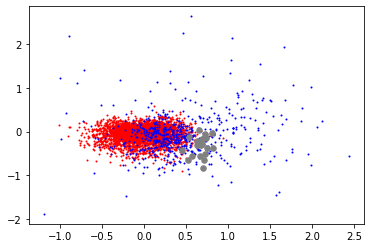

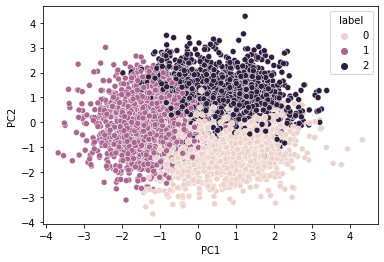

In [92]:
plt.scatter(Zp[:numMovies.item(),0],Zp[:numMovies.item(),1],c="red",s=1)
plt.scatter(Zp[numMovies.item():,0],Zp[numMovies.item():,1],c="blue",s=1) #5-3-1
plt.scatter(new_zpx,new_zpy,c="grey",s=30) #5-3-2

plt.show()
#5-3-3
import seaborn as sns
sns.scatterplot(data=new_df533,x='PC1', y='PC2',hue='label') 
plt.show()